---

<h2 style="text-align: center;"><b>FashionMNIST</b></h2>

---

В этом ноутбуке Вам предстоит самостоятельно попрактиковаться в написаноо нейросетей для распознавания датасета, похожего на MNIST, но более интересного -- чёрно-белых изображений одежды.

<h2 style="text-align: center;"><b>FashionMNIST</b></h2>

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

<h2 style="text-align: center;"><b>Данные</b></h2>

Мы будем работать с картинками одежды (чёрно-белыми, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

import torch
import torchvision

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top','Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

Посмотрите на датасет.
* Сколько в нём классов?
* Сколько картинок в train? В test?
* Равномерно ли распределено количество классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

In [3]:
train_len = len(trainloader.dataset.data)
print(train_len)

60000


In [4]:
test_len = len(testloader.dataset.data)
print(test_len)

10000


In [5]:
trainloader.dataset.data.shape


torch.Size([60000, 28, 28])

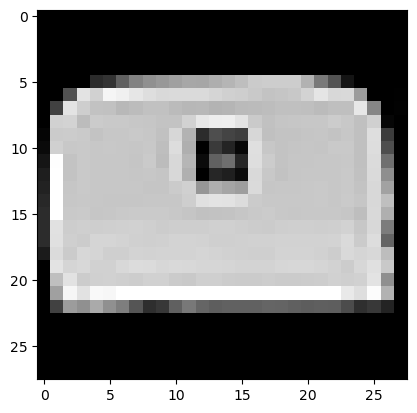

In [6]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=train_len)

plt.imshow(trainloader.dataset.data[i].numpy(), cmap='gray');

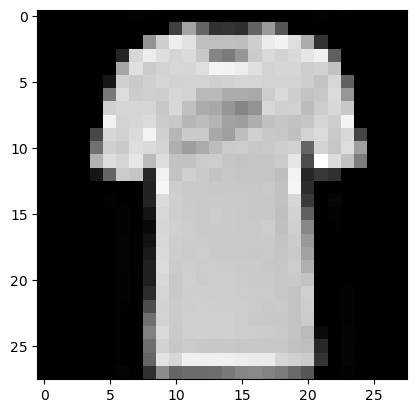

In [53]:
# случайный индекс от 0 до размера тестовой выборки
i = np.random.randint(low=0, high=test_len)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

<h2 style="text-align: center;"><b>Задание</b></h2>

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1. MLP, классифицирующий этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

In [7]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [311]:
class ConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(ConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        
        self.dropout = nn.Dropout(p=0.1)
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bn1 = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(64)
        
        #self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!! 4 * 4 * 16
        #self.fc2 = nn.Linear(120, 84)
        #self.fc3 = nn.Linear(84, 10)
        
        self.fc1 = nn.Linear(2 * 2 * 64, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.elu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.elu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.elu(self.bn3(self.conv3(x)))
        #x = self.pool2(x)
        x = F.elu(self.bn4(self.conv4(x)))
        
        #print(x.shape)
        x = x.view(-1, 2 * 2 * 64)  # !!!
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        #x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [312]:
from tqdm.notebook import tqdm

In [315]:
# объявляем сеть
net = ConvNet()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()


   
# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся

for epoch in tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
    
        # обнуляем веса
        optimizer.zero_grad()
  
        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.815
[1,  4000] loss: 0.487
[1,  6000] loss: 0.431
[1,  8000] loss: 0.406
[1, 10000] loss: 0.397
[1, 12000] loss: 0.384
[1, 14000] loss: 0.387


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.347
[2,  4000] loss: 0.348
[2,  6000] loss: 0.345
[2,  8000] loss: 0.345
[2, 10000] loss: 0.331
[2, 12000] loss: 0.317
[2, 14000] loss: 0.317


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.313
[3,  4000] loss: 0.307
[3,  6000] loss: 0.302
[3,  8000] loss: 0.300
[3, 10000] loss: 0.303
[3, 12000] loss: 0.299
[3, 14000] loss: 0.292


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.281
[4,  4000] loss: 0.271
[4,  6000] loss: 0.279
[4,  8000] loss: 0.278
[4, 10000] loss: 0.276
[4, 12000] loss: 0.293
[4, 14000] loss: 0.286


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.271
[5,  4000] loss: 0.279
[5,  6000] loss: 0.264
[5,  8000] loss: 0.272
[5, 10000] loss: 0.239
[5, 12000] loss: 0.270
[5, 14000] loss: 0.262


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 0.237
[6,  4000] loss: 0.258
[6,  6000] loss: 0.253
[6,  8000] loss: 0.261
[6, 10000] loss: 0.253
[6, 12000] loss: 0.265
[6, 14000] loss: 0.248


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 0.238
[7,  4000] loss: 0.236
[7,  6000] loss: 0.238
[7,  8000] loss: 0.244
[7, 10000] loss: 0.241
[7, 12000] loss: 0.247
[7, 14000] loss: 0.240


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 0.225
[8,  4000] loss: 0.238
[8,  6000] loss: 0.236
[8,  8000] loss: 0.232
[8, 10000] loss: 0.233
[8, 12000] loss: 0.237
[8, 14000] loss: 0.233


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 0.214
[9,  4000] loss: 0.226
[9,  6000] loss: 0.225
[9,  8000] loss: 0.232
[9, 10000] loss: 0.222
[9, 12000] loss: 0.227
[9, 14000] loss: 0.228


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 0.216
[10,  4000] loss: 0.220
[10,  6000] loss: 0.221
[10,  8000] loss: 0.217
[10, 10000] loss: 0.227
[10, 12000] loss: 0.209
[10, 14000] loss: 0.212
Обучение закончено


In [336]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/2500 [00:00<?, ?it/s]

Accuracy of T-shirt/top : 85 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 84 %
Accuracy of Dress : 93 %
Accuracy of  Coat : 79 %
Accuracy of Sandal : 97 %
Accuracy of Shirt : 71 %
Accuracy of Sneaker : 95 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 96 %


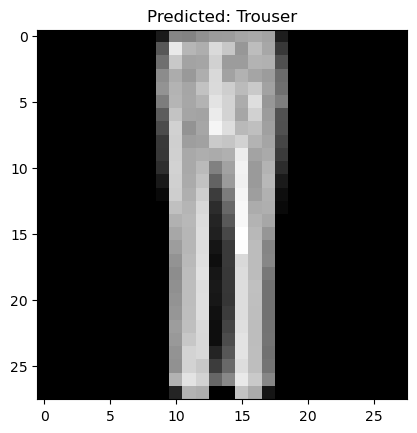

In [334]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.data[index].numpy()
    plt.imshow(image, cmap='gray')
    
    y_pred = net(torch.Tensor(image).view(1, 1, 28, 28))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)

MLP:

In [257]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        #print(x.shape)
        # 4 * 4 * 16
        x = x.view(-1, 784)  # !!!
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

In [354]:
# объявляем сеть
net_mlp = MLP()

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()


   
# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net_mlp.parameters(), lr=learning_rate)

# итерируемся

for epoch in tqdm(range(30)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
    
        # обнуляем веса
        optimizer.zero_grad()
  
        # forward + backward + optimize
        y_pred = net_mlp(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

[1,  2000] loss: 0.960
[1,  4000] loss: 0.597
[1,  6000] loss: 0.538
[1,  8000] loss: 0.504
[1, 10000] loss: 0.476
[1, 12000] loss: 0.473
[1, 14000] loss: 0.466


  0%|          | 0/15000 [00:00<?, ?it/s]

[2,  2000] loss: 0.426
[2,  4000] loss: 0.431
[2,  6000] loss: 0.414
[2,  8000] loss: 0.400
[2, 10000] loss: 0.419
[2, 12000] loss: 0.409
[2, 14000] loss: 0.381


  0%|          | 0/15000 [00:00<?, ?it/s]

[3,  2000] loss: 0.398
[3,  4000] loss: 0.375
[3,  6000] loss: 0.373
[3,  8000] loss: 0.388
[3, 10000] loss: 0.366
[3, 12000] loss: 0.365
[3, 14000] loss: 0.368


  0%|          | 0/15000 [00:00<?, ?it/s]

[4,  2000] loss: 0.359
[4,  4000] loss: 0.342
[4,  6000] loss: 0.361
[4,  8000] loss: 0.364
[4, 10000] loss: 0.349
[4, 12000] loss: 0.343
[4, 14000] loss: 0.350


  0%|          | 0/15000 [00:00<?, ?it/s]

[5,  2000] loss: 0.326
[5,  4000] loss: 0.347
[5,  6000] loss: 0.328
[5,  8000] loss: 0.342
[5, 10000] loss: 0.338
[5, 12000] loss: 0.325
[5, 14000] loss: 0.336


  0%|          | 0/15000 [00:00<?, ?it/s]

[6,  2000] loss: 0.327
[6,  4000] loss: 0.326
[6,  6000] loss: 0.317
[6,  8000] loss: 0.311
[6, 10000] loss: 0.323
[6, 12000] loss: 0.323
[6, 14000] loss: 0.320


  0%|          | 0/15000 [00:00<?, ?it/s]

[7,  2000] loss: 0.312
[7,  4000] loss: 0.292
[7,  6000] loss: 0.301
[7,  8000] loss: 0.316
[7, 10000] loss: 0.308
[7, 12000] loss: 0.312
[7, 14000] loss: 0.312


  0%|          | 0/15000 [00:00<?, ?it/s]

[8,  2000] loss: 0.302
[8,  4000] loss: 0.295
[8,  6000] loss: 0.303
[8,  8000] loss: 0.298
[8, 10000] loss: 0.305
[8, 12000] loss: 0.302
[8, 14000] loss: 0.289


  0%|          | 0/15000 [00:00<?, ?it/s]

[9,  2000] loss: 0.313
[9,  4000] loss: 0.296
[9,  6000] loss: 0.275
[9,  8000] loss: 0.275
[9, 10000] loss: 0.286
[9, 12000] loss: 0.277
[9, 14000] loss: 0.294


  0%|          | 0/15000 [00:00<?, ?it/s]

[10,  2000] loss: 0.283
[10,  4000] loss: 0.286
[10,  6000] loss: 0.279
[10,  8000] loss: 0.272
[10, 10000] loss: 0.281
[10, 12000] loss: 0.286
[10, 14000] loss: 0.282


  0%|          | 0/15000 [00:00<?, ?it/s]

[11,  2000] loss: 0.274
[11,  4000] loss: 0.275
[11,  6000] loss: 0.268
[11,  8000] loss: 0.259
[11, 10000] loss: 0.269
[11, 12000] loss: 0.290
[11, 14000] loss: 0.260


  0%|          | 0/15000 [00:00<?, ?it/s]

[12,  2000] loss: 0.259
[12,  4000] loss: 0.263
[12,  6000] loss: 0.262
[12,  8000] loss: 0.262
[12, 10000] loss: 0.262
[12, 12000] loss: 0.269
[12, 14000] loss: 0.267


  0%|          | 0/15000 [00:00<?, ?it/s]

[13,  2000] loss: 0.262
[13,  4000] loss: 0.241
[13,  6000] loss: 0.250
[13,  8000] loss: 0.259
[13, 10000] loss: 0.265
[13, 12000] loss: 0.264
[13, 14000] loss: 0.255


  0%|          | 0/15000 [00:00<?, ?it/s]

[14,  2000] loss: 0.260
[14,  4000] loss: 0.243
[14,  6000] loss: 0.254
[14,  8000] loss: 0.249
[14, 10000] loss: 0.247
[14, 12000] loss: 0.245
[14, 14000] loss: 0.249


  0%|          | 0/15000 [00:00<?, ?it/s]

[15,  2000] loss: 0.246
[15,  4000] loss: 0.254
[15,  6000] loss: 0.236
[15,  8000] loss: 0.240
[15, 10000] loss: 0.249
[15, 12000] loss: 0.249
[15, 14000] loss: 0.242


  0%|          | 0/15000 [00:00<?, ?it/s]

[16,  2000] loss: 0.241
[16,  4000] loss: 0.243
[16,  6000] loss: 0.232
[16,  8000] loss: 0.234
[16, 10000] loss: 0.241
[16, 12000] loss: 0.234
[16, 14000] loss: 0.244


  0%|          | 0/15000 [00:00<?, ?it/s]

[17,  2000] loss: 0.241
[17,  4000] loss: 0.234
[17,  6000] loss: 0.232
[17,  8000] loss: 0.242
[17, 10000] loss: 0.223
[17, 12000] loss: 0.224
[17, 14000] loss: 0.235


  0%|          | 0/15000 [00:00<?, ?it/s]

[18,  2000] loss: 0.207
[18,  4000] loss: 0.239
[18,  6000] loss: 0.224
[18,  8000] loss: 0.226
[18, 10000] loss: 0.224
[18, 12000] loss: 0.220
[18, 14000] loss: 0.242


  0%|          | 0/15000 [00:00<?, ?it/s]

[19,  2000] loss: 0.219
[19,  4000] loss: 0.217
[19,  6000] loss: 0.221
[19,  8000] loss: 0.225
[19, 10000] loss: 0.216
[19, 12000] loss: 0.223
[19, 14000] loss: 0.231


  0%|          | 0/15000 [00:00<?, ?it/s]

[20,  2000] loss: 0.205
[20,  4000] loss: 0.226
[20,  6000] loss: 0.223
[20,  8000] loss: 0.228
[20, 10000] loss: 0.215
[20, 12000] loss: 0.215
[20, 14000] loss: 0.222


  0%|          | 0/15000 [00:00<?, ?it/s]

[21,  2000] loss: 0.218
[21,  4000] loss: 0.212
[21,  6000] loss: 0.214
[21,  8000] loss: 0.202
[21, 10000] loss: 0.213
[21, 12000] loss: 0.208
[21, 14000] loss: 0.226


  0%|          | 0/15000 [00:00<?, ?it/s]

[22,  2000] loss: 0.209
[22,  4000] loss: 0.198
[22,  6000] loss: 0.222
[22,  8000] loss: 0.200
[22, 10000] loss: 0.212
[22, 12000] loss: 0.209
[22, 14000] loss: 0.213


  0%|          | 0/15000 [00:00<?, ?it/s]

[23,  2000] loss: 0.192
[23,  4000] loss: 0.205
[23,  6000] loss: 0.203
[23,  8000] loss: 0.196
[23, 10000] loss: 0.214
[23, 12000] loss: 0.212
[23, 14000] loss: 0.202


  0%|          | 0/15000 [00:00<?, ?it/s]

[24,  2000] loss: 0.199
[24,  4000] loss: 0.199
[24,  6000] loss: 0.194
[24,  8000] loss: 0.205
[24, 10000] loss: 0.203
[24, 12000] loss: 0.195
[24, 14000] loss: 0.204


  0%|          | 0/15000 [00:00<?, ?it/s]

[25,  2000] loss: 0.193
[25,  4000] loss: 0.197
[25,  6000] loss: 0.189
[25,  8000] loss: 0.195
[25, 10000] loss: 0.200
[25, 12000] loss: 0.205
[25, 14000] loss: 0.192


  0%|          | 0/15000 [00:00<?, ?it/s]

[26,  2000] loss: 0.192
[26,  4000] loss: 0.176
[26,  6000] loss: 0.198
[26,  8000] loss: 0.187
[26, 10000] loss: 0.197
[26, 12000] loss: 0.196
[26, 14000] loss: 0.189


  0%|          | 0/15000 [00:00<?, ?it/s]

[27,  2000] loss: 0.192
[27,  4000] loss: 0.204
[27,  6000] loss: 0.178
[27,  8000] loss: 0.196
[27, 10000] loss: 0.184
[27, 12000] loss: 0.186
[27, 14000] loss: 0.176


  0%|          | 0/15000 [00:00<?, ?it/s]

[28,  2000] loss: 0.185
[28,  4000] loss: 0.182
[28,  6000] loss: 0.180
[28,  8000] loss: 0.185
[28, 10000] loss: 0.185
[28, 12000] loss: 0.195
[28, 14000] loss: 0.180


  0%|          | 0/15000 [00:00<?, ?it/s]

[29,  2000] loss: 0.181
[29,  4000] loss: 0.175
[29,  6000] loss: 0.185
[29,  8000] loss: 0.179
[29, 10000] loss: 0.180
[29, 12000] loss: 0.181
[29, 14000] loss: 0.180


  0%|          | 0/15000 [00:00<?, ?it/s]

[30,  2000] loss: 0.170
[30,  4000] loss: 0.179
[30,  6000] loss: 0.178
[30,  8000] loss: 0.176
[30, 10000] loss: 0.174
[30, 12000] loss: 0.180
[30, 14000] loss: 0.176
Обучение закончено


In [355]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net_mlp(images)
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 86 %
Accuracy of Trouser : 97 %
Accuracy of Pullover : 79 %
Accuracy of Dress : 87 %
Accuracy of  Coat : 82 %
Accuracy of Sandal : 94 %
Accuracy of Shirt : 73 %
Accuracy of Sneaker : 94 %
Accuracy of   Bag : 96 %
Accuracy of Ankle boot : 96 %


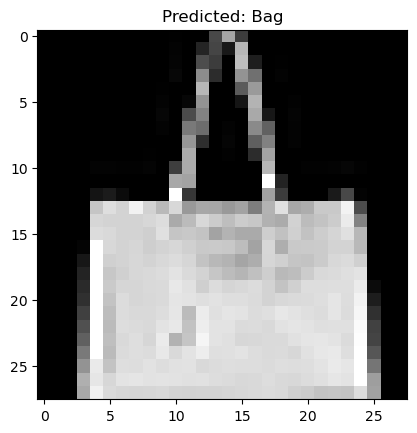

In [269]:
i = np.random.randint(low=0, high=10000)

def visualize_result(index):
    image = testloader.dataset.test_data[index].numpy()
    plt.imshow(image, cmap='gray')
    
    y_pred = net_mlp(torch.Tensor(image).view(1, 1, 28, 28))
    _, predicted = torch.max(y_pred, 1)
    
    plt.title(f'Predicted: {classes[predicted.numpy()[0]]}')

visualize_result(i)